# Notebook #1 - Sequential simulation for initialization of simultaneous simulation for ammonia synthesis with dynamic catalysis

This Jupyter Notebook is part of the Supporting Information for the ESCAPE Conference paper "Dynamic Catalysis for Ammonia Synthesis: Cyclic Steady-State Simulation and Insights into Forcing Signal Parameters" by Carolina Colombo Tedesco, John R. Kitchin, and Carl Laird. 

Feel free to open an issue on GitHub (https://github.com/ccolomb2/dynamic_catalysis_NH3) or contact the author or if you have any questions (ccolomb@andrew.cmu.edu).

In [1]:
from munch import Munch
import numpy as np
from pyomo.environ import (ConcreteModel, Constraint, Objective, Var, Param, Reals, NonNegativeReals,
                           SolverFactory, value, sin, cos, Set, exp, Any, ConstraintList,
                           TransformationFactory, assert_optimal_termination, RangeSet, maximize)
from pyomo.dae import ContinuousSet, DerivativeVar
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from scipy.integrate import solve_ivp
import pandas as pd
from scipy import signal
from tqdm import tqdm 
# import idaes
from scipy.optimize import minimize
import time
import pandas as pd
import csv
import math
from IPython.display import Image, display
from tqdm import tqdm
from scipy.interpolate import interp1d
from pyomo.core.expr.visitor import identify_variables
from pyomo.core.expr import differentiate
from matplotlib.ticker import FormatStrFormatter
from scipy.interpolate import Akima1DInterpolator
import csv


In [2]:
class Params:
    """
    Declares reaction system and CSTR model parameters
    """
    
    def __init__(self,  T = 593.15, # K
                        T_orig = 593.15, # K                                    
                        T_gas = 593.15, # K
                        T_ref = 1,
                        T_c = 500, # K
                        Q_in = 1, # cm3/s
                        Q_out = 1,
                        P = 50, # atm
                        R_e = 1.987e-3, # kcal/mol K
                        R_k = 8.31451e7, # g cm2/mol K s
                        R = 82.057, # cm3 atm/K mol
                        V = 1.0, # cm3
                        SDTOT = 2.6188e-9, # moles/cm2
                        RATIO_S = 0.02,                     
                        abyv = 1200, # cm2 catalyst/cm3 reac volume
                        MW_H = 1.00797, # g/mol
                        MW_N = 14.0067, # g/mol
                        MWON = 0, # g/mol
                        X_H2  = 3,                     
                        X_N2  = 1,                   
                        X_NH3 = 0, 
                        beta = np.array([0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1]),
                        Stick = np.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5]),
                        Isobaric = 0,
                        A = np.array([0, 0, 0, 0, 0, 0, 0, 0, 1.56E19, 1.56E19, 1.56E19, 1.56E19, 1.56E19, \
                                      0, 0, 1.56E19]).reshape(16,1),
                        StrainCoef = [-0.04, 0.0, 0.04],
                        Q_ref = 134.21,
                        Q_target = 134.21, # binding energy of Ru 
                        alpha = np.array([0.62036, 1, 0.17, 0.14, 0.41, 0.71, 0.62036, 1.057, 0.18, 0.14, 0.391, 0.708, 1.057]),
                        Qi_ref = np.array([-2.0779, 134.21, 57.4245, 12.2999, 45.8833, 82.5372, 9.451, 106.224, 58.0824, 22.6759, 
                        63.9298, 91.8554, 106.224]),
                        mb = [0.514, 0.581, 0.725, 0.608, 0.855,0.809, 0.553, 0.470,0.183, 0.346],
                        b = [48.6,28.0,25.5,27.5,40.6,26.5,27.7,22.3,18.0,20.1],
                        ):
   
        self.T = T # Temperature on the simulated CSTR
        self.T_orig = T_orig 
        self.T_gas = T_gas 
        self.T_c = T_c 
        self.T_ref = T_ref
        self.Q_in = Q_in 
        self.Q_out = Q_out 
        self.P = P # Standard pressure
        self.R_e = R_e
        self.R_k = R_k
        self.R = R 
        self.V = V 
        self.SDTOT = SDTOT 
        self.RATIO_S = RATIO_S
        self.abyv  = abyv
        self.MW_H = MW_H
        self.MW_N = MW_N 
        self.MWON = MWON 
        self.X_H2 = X_H2 
        self.X_N2 = X_N2 
        self.X_NH3 = X_NH3 
        self.beta = beta 
        self.Stick = Stick 
        self.Isobaric = Isobaric 
        self.A = A
        self.StrainCoef = StrainCoef
        self.Q_ref = Q_ref
        self.Q_target = Q_target # binding energy of Ru 
        self.Qi_ref = Qi_ref
        self.mb = mb
        self.b = b
        self.alpha = alpha

In [3]:
params = Params()

In [4]:
def initial_calculations(params):

    RATIO_S = params.RATIO_S
    SDTOT  = params.SDTOT 
    MW_H = params.MW_H
    MW_N = params.MW_N  
    X_H2 = params.X_H2  
    X_N2 = params.X_N2  
    X_NH3 = params.X_NH3
    P = params.P
    R = params.R 
    T = params.T
    X_N2 = params.X_N2  
    X_NH3 = params.X_NH3
    
    SDEN_T = (1 - RATIO_S) * SDTOT 
    SDEN_S = RATIO_S * SDTOT

    MW_H2 = 2*MW_H # g/mol            
    MW_N2 = 2*MW_N # g/mol            
    MW_NH3 = MW_N + 3*MW_H # g/mol

    Y_H2  = X_H2 /(X_H2+X_N2+X_NH3)
    Y_N2  = X_N2 /(X_H2+X_N2+X_NH3)
    Y_NH3 = X_NH3/(X_H2+X_N2+X_NH3)  
    c_tot = P/(R*T) # mol/cm3
    c_H2 = Y_H2*c_tot # mol/cm3
    c_N2 = Y_N2*c_tot # mol/cm3
    c_NH3 = Y_NH3*c_tot # mol/cm3
    
    
    return Munch(SDEN_T=SDEN_T, SDEN_S=SDEN_S, MW_H2=MW_H2, MW_N2=MW_N2, MW_NH3=MW_NH3, Y_H2=Y_H2, \
                 Y_NH3=Y_NH3, c_tot=c_tot, c_H2=c_H2, c_N2=c_N2, c_NH3=c_NH3)


In [5]:
# code source: chatGPT

data = {}

# Read the CSV file with DFT and thermodnamic data
with open('data_ammonia.csv', mode='r') as file:
    reader = csv.reader(file)
    current_section = None  # Track the current section label
    temp_data = []          # Temporarily hold data for a section

    for row in reader:
        # Strip any whitespace and skip empty rows
        row = [val.strip() for val in row]
        if not any(row):
            continue  # Skip blank rows

        # If the row is a label, save the current section data and start a new section
        if len(row) == 1:  # A label row
            if current_section is not None and temp_data:
                # Save the previous section's data
                data[current_section] = (
                    np.array(temp_data, dtype=float) 
                    if len(temp_data[0]) > 1 else np.array(temp_data, dtype=float).flatten()
                )
                temp_data = []  # Reset for the next section
            
            current_section = row[0]  # Update the current section label
        
        elif current_section:  # Data row (non-empty)
            try:
                temp_data.append([float(val) for val in row])  # Parse as float
            except ValueError:
                print(f"Warning: Could not parse row: {row}")

    # Save the last section
    if current_section is not None and temp_data:
        data[current_section] = (
            np.array(temp_data, dtype=float) 
            if len(temp_data[0]) > 1 else np.array(temp_data, dtype=float).flatten()
        )



In [6]:
# Extract parsed data into variables
Stoic = data.get("Stoic")
Strain_Coef_H = data.get("Strain_Coef_H")
Strain_Coef_S = data.get("Strain_Coef_S")
A_LSR = data.get("A_LSR")

# Extract specific parameters dynamically
A_N2s1_h = data.get("A_N2s1_h")
A_N2s1_l = data.get("A_N2s1_l")
A_Ns1_h = data.get("A_Ns1_h")
A_Ns1_l = data.get("A_Ns1_l")
A_Hs1_h = data.get("A_Hs1_h")
A_Hs1_l = data.get("A_Hs1_l")
A_NH3s1_h = data.get("A_NH3s1_h")
A_NH3s1_l = data.get("A_NH3s1_l")
A_NH2s1_h = data.get("A_NH2s1_h")
A_NH2s1_l = data.get("A_NH2s1_l")
A_NHs1_h = data.get("A_NHs1_h")
A_NHs1_l = data.get("A_NHs1_l")
A_N2s2_h = data.get("A_N2s2_h")
A_N2s2_l = data.get("A_N2s2_l")
A_Ns2_h = data.get("A_Ns2_h")
A_Ns3_l = data.get("A_Ns3_l")
A_Ns3_h = data.get("A_Ns3_h")
A_Ns2_l = data.get("A_Ns2_l")
A_Hs2_h = data.get("A_Hs2_h")
A_Hs2_l = data.get("A_Hs2_l")
A_NH3s2_h = data.get("A_NH3s2_h")
A_NH3s2_l = data.get("A_NH3s2_l")
A_NH2s2_h = data.get("A_NH2s2_h")
A_NH2s2_l = data.get("A_NH2s2_l")
A_NHs2_h = data.get("A_NHs2_h")
A_NHs2_l = data.get("A_NHs2_l")
A_H2_h = data.get("A_H2_h")
A_H2_l = data.get("A_H2_l")
A_N2_h = data.get("A_N2_h")
A_N2_l = data.get("A_N2_l")
A_NH3_h = data.get("A_NH3_h")
A_NH3_l = data.get("A_NH3_l")
A_v_h = data.get("A_v_h")
A_v_l = data.get("A_v_l")

In [7]:
def amm_thermo4(params, A6_LSR,A6_Strain,A7_Strain):

    """
    This function uses thermodynamic parameters depending on the temperature and calculates 
    and returns Cp/R, H/RT and G/RT
    """
        
    
    T = params.T
    T_c = params.T_c
    

    if T > 791.5:
        A_H2 = A_H2_h
        A_N2 = A_N2_h
    else:
        A_H2 = A_H2_l
        A_N2 = A_N2_l

    if T > 592.4:
        A_NH3 = A_NH3_h
    else:
        A_NH3 = A_NH3_l

    A_h = [A_N2s1_h, A_Ns1_h, A_Hs1_h, A_NH3s1_h, A_NH2s1_h, A_NHs1_h, A_N2, A_H2, A_NH3, A_v_h,
           A_N2s2_h, A_Ns2_h, A_Hs2_h, A_NH3s2_h, A_NH2s2_h, A_NHs2_h, A_v_h, A_Ns3_h]

    A_l = [A_N2s1_l, A_Ns1_l, A_Hs1_l, A_NH3s1_l, A_NH2s1_l, A_NHs1_l, A_N2, A_H2, A_NH3, A_v_l,
           A_N2s2_l, A_Ns2_l, A_Hs2_l, A_NH3s2_l, A_NH2s2_l, A_NHs2_l, A_v_l, A_Ns3_l]

    if T > T_c:
        A_thermo = A_h
    else:
        A_thermo = A_l

            # Collapse A_thermo from shape (18, 7, 1) to (18, 7)
    A_thermo = np.squeeze(A_thermo, axis=1)  # Remove the last dimension
    
    A6_Correction = A6_LSR - A6_Strain

    
    # Subtract A6_Correction from specific rows of column 6 in A
    A_thermo[0:6, 5] -= A6_Correction[0:6, 0]
    A_thermo[10:16, 5] -= A6_Correction[6:12, 0]
    A_thermo[17, 5] -= A6_Correction[12, 0]

    # Add A7_Strain to specific rows of column 7 in A
    A_thermo[0:6, 6] += A7_Strain[0:6, 0]
    A_thermo[10:16, 6] += A7_Strain[6:12, 0]
    A_thermo[17, 6] += A7_Strain[12, 0]
     
    T_Cp = [1, T, T**2, T**3, T**4]
    T_H = [1, T/2, T**2/3, T**3/4, T**4/5, 1/T]
    T_S = [np.log(T), T, T**2/2, T**3/3, T**4/4, 1]

    CpOR = np.dot(T_Cp, A_thermo[:, :5].T)
    HORT = np.dot(T_H, A_thermo[:, :6].T)
    
    columns = [0, 1, 2, 3, 4, 6]
    A_columns = A_thermo[:, columns]
    SOR = np.dot(T_S, A_columns.T)
                 
    GORT = HORT - SOR
    
    return HORT, GORT

In [8]:
def amm_BEP_LSR4(params, strain):
    
    T = params.T
    Q_ref = params.Q_ref
    Q_target = params.Q_target
    alpha = params.alpha
    Qi_ref = params.Qi_ref
    R_e = params.R_e
    A = params.A
    mb = params.mb
    b = params.b

    # these operations work and the results is an array with 13 elements
    Q = Qi_ref + alpha * (Q_target - Q_ref)
    A6_LSR = ((alpha * (Q_target - Q_ref)) / R_e).reshape(13,1)

    
    # these A depend on strain, and they are given to the thermo function as inputs
    # they serve as correction to calculate the thermo parameters Cp, H, G
    A6_Strain = (Strain_Coef_H @ np.array([strain, 1])).reshape(13,1)
    A7_Strain = (Strain_Coef_S @ np.array([strain ** 2, strain, 1])).reshape(13,1)
    A_New = np.dot(A_LSR, np.array([strain ** 2, strain, 1]))
    A[0:8, 0] = A_New[0:8]
    A[13:15, 0] = A_New[8:10]

    HORT, GORT = amm_thermo4(params, A6_LSR, A6_Strain, A7_Strain)
    
    # heat of reaction calculated from 
    HRXN = np.dot(HORT, np.dot(Stoic.T, T * R_e))
    
    Ea = np.zeros(22)
    
    # corrected!
    Ea[1] = mb[0] * HRXN[1] + b[0] # N2 dissociation (Terrace)
    
    # corrected!
    Ea[3] = mb[3] * HRXN[3] + b[3] # NH3 dehydrogenation (Terrace)
    
     # corrected!
    Ea[4] = mb[2] * HRXN[4] + b[2] # NH2 dehydrogenation (Terrace)
    
    # corrected!
    Ea[5] = mb[1] * HRXN[5] + b[1]  # NH dehydrogenation (Terrace)
    
    
    # Reactions 6, 7 and 9 are adsorptions, here considered barrierless
    
    
    Ea[8] = mb[4] * HRXN[8] + b[4] # N2 dissociation (Step), considered as non-happening
    
    # corrected!
    Ea[10] = mb[7] * HRXN[10] + b[7] # NH3 dehydrogenation (Step)
    
    # corrected!
    Ea[11] = mb[6] * HRXN[11] + b[6] # NH2 dehydrogenation (Step)
    
    # corrected!
    Ea[12] = mb[5] * HRXN[12] + b[5] # NH dehydrogenation (Step)
    
    Ea[14] = (strain * 100) * (0.46921131) + 20.20056000 # N* Diffusion
    Ea[15] = (strain * 100) * (0.10199344) + 9.27356278 # H* Diffusion
    Ea[16] = (strain * 100) * (0.06629750) + 13.18263333 # NH3* Diffusion
    Ea[17] = (strain * 100) * (0.14124250) + 5.34992000 #  NH2* Diffusion
    Ea[18] = (strain * 100) * (0.23348250) + 15.03512000 # NH* Diffusion
    
    # corrected!
    Ea[19] = mb[8] * HRXN[19] + b[8] # N2 dissociation (Step-Terrace)
    
    # corrected!
    Ea[20] = mb[9] * HRXN[20] + b[9] # N2 dissociation (U Step-L Step)
    Ea[21] = (strain * 100) * (0.46921131) + 20.20056000 # N(S3) Diffusion
    
    return Ea, GORT, A

In [9]:
def amm_kinetics4(params,  t, strain):
    
    T = params.T
    R_e = params.R_e
    R_k = params.R_k
    R = params.R
    A = params.A
    Stick = params.Stick
    SDTOT = params.SDTOT
    abyv = params.abyv
    beta = params.beta
    T_ref = params.T_ref
    MWON = params.MWON
    T_gas = params.T_gas
    
    ic = initial_calculations(params)
    
    Ea, GORT,  A = amm_BEP_LSR4(params, strain)

    Stoic_gas = np.zeros((22, 18))
    Stoic_gas[0, 6] = -1
    Stoic_gas[2, 7] = -1
    Stoic_gas[7, 6] = -1
    Stoic_gas[6, 8] = -1
    Stoic_gas[9, 7] = -1
    Stoic_gas[13, 8] = -1
    
    kf = np.zeros(22)

    # Terrace site reactions
    # Ea[0] = 0 per initiation of the array, means there is no energy barrier for this adsorption
    kf[0] = 1 * (Stick[0] / (1 - MWON * Stick[0] / 2)) / SDTOT * ((T_gas / T_ref) ** beta[0]) * \
            np.sqrt(R_k * T_gas / (2 * np.pi * ic.MW_N2)) * np.exp(-Ea[0] / (R_e * T_gas))  # N2   +  *(T) <--> N2(T)
    
    # here matlab uses Ea(2), which is calculated
    kf[1] = 1 * A[0] * ((T / T_ref) ** beta[1]) / abyv * np.exp(-Ea[1] / (R_e * T))  # N2(T)  +  *(T) <--> 2N(T)
    
    # stick[1] seems correct. 
    # this ea should be zero, and it is.
    kf[2] = 1 * (Stick[1] / (1 - MWON * Stick[1] / 2)) / (abyv * SDTOT ** 2) * \
            ((T_gas / T_ref) ** beta[2]) * np.sqrt(R_k * T_gas / (2 * np.pi * ic.MW_H2)) * \
            np.exp(-Ea[2] / (R_e * T_gas))  # H2   + 2(T) <--> 2H(T)
    
    # ok, ea formula corrected
    kf[3] = 1 * A[1] * ((T / T_ref) ** beta[3]) / abyv * np.exp(-Ea[3] / (R_e * T))  # NH3(T) +  *(T) <--> NH2(T) + H(T)
    
    # ok, ea formula corrected
    kf[4] = 1 * A[2] * ((T / T_ref) ** beta[4]) / abyv * np.exp(-Ea[4] / (R_e * T))  # NH2(T) +  *(T) <--> NH(T)  + H(T)
    
    # ok, ea formula corrected    
    kf[5] = 1 * A[3] * ((T / T_ref) ** beta[5]) / abyv * np.exp(-Ea[5] / (R_e * T))  # NH(T)  +  *(T) <--> N(T)   + H(T)
   
    # this ea should be zero, and it is.
    kf[6] = 1 * (Stick[2] / (1 - MWON * Stick[2] / 2)) / SDTOT * ((T_gas / T_ref) ** beta[6]) * \
            np.sqrt(R_k * T_gas / (2 * np.pi * ic.MW_NH3)) * np.exp(-Ea[6] / (R_e * T_gas))  # NH3  +  *(T) <--> NH3(T)

    # Step site reactions
    kf[7] = 1 * (Stick[3] / (1 - MWON * Stick[3] / 2)) / SDTOT * ((T_gas / T_ref) ** beta[7]) * \
            np.sqrt(R_k * T_gas / (2 * np.pi * ic.MW_N2)) * np.exp(-Ea[7] / (R_e * T_gas))  # N2 + *(S) <--> N2(S1)
    
    # we consider this reaction does not happen
    # it is indeed my reaction 8, so ok
    # kf[8] = 0 * A[4] * ((T / T_ref) ** beta[8]) / abyv * np.exp(-Ea[8] / (R_e * T))  # N2(S) + *(S) <--> 2N(S)
    
    # this ea should be zero, and it is.
    kf[9] = 1 * (Stick[4] / (1 - MWON * Stick[4] / 2)) / (abyv * SDTOT ** 2) * \
            ((T_gas / T_ref) ** beta[9]) * np.sqrt(R_k * T_gas / (2 * np.pi * ic.MW_H2)) * \
            np.exp(-Ea[9] / (R_e * T_gas))  # H2 + 2(S) <--> 2H(S)
    
    kf[10] = 1 * A[5] * ((T / T_ref) ** beta[10]) / abyv * np.exp(-Ea[10] / (R_e * T))  # NH3(S) + *(S) <--> NH2(S) + H(S)
    
    kf[11] = 1 * A[6] * ((T / T_ref) ** beta[11]) / abyv * np.exp(-Ea[11] / (R_e * T))  # NH2(S) + *(S) <--> NH(S) + H(S)

    kf[12] = 1 * A[7] * ((T / T_ref) ** beta[12]) / abyv * np.exp(-Ea[12] / (R_e * T))  # NH(S) + *(S) <--> N(S) + H(S)

    # this ea should be zero, and it is.
    kf[13] = 1 * (Stick[5] / (1 - MWON * Stick[5] / 2)) / SDTOT * ((T_gas / T_ref) ** beta[13]) * \
             np.sqrt(R_k * T_gas / (2 * np.pi * ic.MW_NH3)) * np.exp(-Ea[13] / (R_e * T_gas))  # NH3  +  *(S) <--> NH3(S)

    # Diffusion reactions
    kf[14] = 1 * A[8] * ((T / T_ref) ** beta[14]) / abyv * np.exp(-Ea[14] / (R_e * T))  # N(T) + *(S) <--> N(S) + *(T)
    # kf[15] = 0 * A[9] * ((T / T_ref) ** beta[15]) / abyv * np.exp(-Ea[15] / (R_e * T))  # H(T) + *(S) <--> H(S) + *(T)
    kf[16] = 1 * A[10] * ((T / T_ref) ** beta[16]) / abyv * np.exp(-Ea[16] / (R_e * T))  # NH3(T) + *(S) <--> NH3(S) + *(T)
    kf[17] = 1 * A[11] * ((T / T_ref) ** beta[17]) / abyv * np.exp(-Ea[17] / (R_e * T))  # NH2(T) + *(S) <--> NH2(S) + *(T)
    kf[18] = 1 * A[12] * ((T / T_ref) ** beta[18]) / abyv * np.exp(-Ea[18] / (R_e * T))  # NH(T) + *(S) <--> NH(S) + *(T)
    # kf[19] = 0 * A[13] * ((T / T_ref) ** beta[19]) / abyv * np.exp(-Ea[19] / (R_e * T))  # N2(S) + *(T) <--> N(S) + N(T)
    kf[20] = 1 * A[14] * ((T / T_ref) ** beta[20]) / abyv * np.exp(-Ea[20] / (R_e * T))  # N2(S) + *(S3) <--> N(S) + N(S3)
    kf[21] = 1 * A[15] * ((T / T_ref) ** beta[21]) / abyv * np.exp(-Ea[21] / (R_e * T))  # N(T) + *(S3) <--> N(S3) + *(T)
    
#     GORT = GORT.reshape(1, 18)    
    GORT_e = GORT @ (Stoic).T
    Kp = np.exp(-GORT_e)
    Kc = Kp * (1 / (R * T)) ** np.sum(Stoic_gas, axis=1)
    kb = kf / Kc

    return kf, kb, strain

In [10]:
ic = initial_calculations(params)

scaling_factor = 1

In [11]:
def ODEs(t, s, params):

    T = params.T
    R = params.R
    A = params.A
    SDTOT = params.SDTOT
    abyv = params.abyv
    MWON = params.MWON
    Q_out = params.Q_out
    Q_in = params.Q_in
    V = params.V

    amplitude = 0.04
    freq_osci = 1000
    offset = 0

    strain = amplitude * np.sin(2 * np.pi * freq_osci * t)
            
    kf, kb, _ = amm_kinetics4(params,  t, strain)

    # print(kf)
    
    N2_T = s[0] / scaling_factor
    N_T = s[1] / scaling_factor
    H_T = s[2] / scaling_factor
    NH3_T = s[3] / scaling_factor
    NH2_T = s[4] / scaling_factor
    NH_T = s[5] / scaling_factor

    N2 = s[6] / scaling_factor
    H2 = s[7] / scaling_factor
    NH3 = s[8] / scaling_factor

    N2_S = s[9] / scaling_factor
    N_S = s[10] / scaling_factor
    H_S = s[11] / scaling_factor
    NH3_S = s[12] / scaling_factor
    NH2_S = s[13] / scaling_factor
    NH_S = s[14] / scaling_factor
    N_S3 = s[15] / scaling_factor



    vac_T = ic.SDEN_T * abyv - (N2_T + N_T + H_T + NH3_T + NH2_T + NH_T)
    vac_S = ic.SDEN_S * abyv - (N2_S + N_S + H_S + NH3_S + NH2_S + NH_S + N_S3)

    

    #### Terrace Sites

    # dN2(T)/dt
    dN2_Tdt = kf[0] * N2 * vac_T - kb[0] * N2_T + kb[1] * (N_T ** 2) - kf[1] * N2_T * vac_T


    # dN(T)/dt
    dN_Tdt = 2 * kf[1] * N2_T * vac_T - 2 * kb[1] * (N_T ** 2) + kf[5] * NH_T * vac_T - kb[5] * N_T * H_T + \
             kb[14] * N_S * vac_T - kf[14] * N_T * vac_S + kf[19] * N2_S * vac_T - kb[19] * N_T * N_S + \
             kb[21] * N_S3 * vac_T - kf[21] * N_T * vac_S

    # dH(T)/dt
    dH_Tdt = 2 * kf[2] * H2 * (vac_T ** 2) - 2 * kb[2] * (H_T ** 2) + kf[3] * NH3_T * vac_T - kb[3] * NH2_T * H_T + \
             kf[4] * NH2_T * vac_T - kb[4] * NH_T * H_T + kf[5] * NH_T * vac_T - kb[5] * N_T * H_T + \
             kb[15] * H_S * vac_T - kf[15] * H_T * vac_S

    # dNH3(T)/dt
    dNH3_Tdt = kb[3] * NH2_T * H_T - kf[3] * NH3_T * vac_T + kf[6] * NH3 * vac_T - kb[6] * NH3_T + \
               kb[16] * NH3_S * vac_T - kf[16] * NH3_T * vac_S

    # dNH2(T)/dt
    dNH2_Tdt = kf[3] * NH3_T * vac_T - kb[3] * NH2_T * H_T + kb[4] * NH_T * H_T - kf[4] * NH2_T * vac_T + \
               kb[17] * NH2_S * vac_T - kf[17] * NH2_T * vac_S

    # dNH(T)/dt
    dNH_Tdt = kf[4] * NH2_T * vac_T - kb[4] * NH_T * H_T + kb[5] * N_T * H_T - kf[5] * NH_T * vac_T + \
              kb[18] * NH_S * vac_T - kf[18] * NH_T * vac_S

    #### Gas Phase

    # dN2/dt
    dN2dt = kb[0] * N2_T - kf[0] * N2 * vac_T + kb[7] * N2_S - kf[7] * N2 * vac_S + Q_in * ic.c_N2 / V - Q_out * N2 / V

    # dH2/dt
    dH2dt = kb[2] * (H_T ** 2) - kf[2] * H2 * (vac_T ** 2) + kb[9] * (H_S ** 2) - kf[9] * H2 * (vac_S ** 2) + \
            Q_in * ic.c_H2 / V - Q_out * H2 / V

    # dNH3/dt
    dNH3dt = kb[6] * NH3_T - kf[6] * NH3 * vac_T + kb[13] * NH3_S - kf[13] * NH3 * vac_S + Q_in * ic.c_NH3 / V - Q_out * NH3 / V

    #### Step Sites

    # dN2(S)/dt
    dN2_Sdt = kf[7] * N2 * vac_S - kb[7] * N2_S + kb[8] * (N_S ** 2) - kf[8] * N2_S * vac_S + \
              kb[19] * N_T * N_S - kf[19] * N2_S * vac_T + kb[20] * N_S * N_S3 - kf[20] * N2_S * vac_S
    

    # dN(S)/dt
    dN_Sdt = 2 * kf[8] * N2_S * vac_S - 2 * kb[8] * (N_S ** 2) + kf[12] * NH_S * vac_S - kb[12] * N_S * H_S + \
             kf[14] * N_T * vac_S - kb[14] * N_S * vac_T + kf[19] * N2_S * vac_T - kb[19] * N_T * N_S + \
             kf[20] * N2_S * vac_S - kb[20] * N_S * N_S3

    # dH(S)/dt
    dH_Sdt = 2 * kf[9] * H2 * (vac_S ** 2) - 2 * kb[9] * (H_S ** 2) + kf[10] * NH3_S * vac_S - kb[10] * NH2_S * H_S + \
             kf[11] * NH2_S * vac_S - kb[11] * NH_S * H_S + kf[12] * NH_S * vac_S - kb[12] * N_S * H_S + \
             kf[15] * H_T * vac_S - kb[15] * H_S * vac_T

    # dNH3(S)/dt
    dNH3_Sdt = kb[10] * NH2_S * H_S - kf[10] * NH3_S * vac_S + kf[13] * NH3 * vac_S - kb[13] * NH3_S + \
               kf[16] * NH3_T * vac_S - kb[16] * NH3_S * vac_T

    # dNH2(S)/dt
    dNH2_Sdt = kf[10] * NH3_S * vac_S - kb[10] * NH2_S * H_S + kb[11] * NH_S * H_S - kf[11] * NH2_S * vac_S + \
               kf[17] * NH2_T * vac_S - kb[17] * NH2_S * vac_T

    # dNH(S)/dt
    dNH_Sdt = kf[11] * NH2_S * vac_S - kb[11] * NH_S * H_S + kb[12] * N_S * H_S - kf[12] * NH_S * vac_S + \
              kf[18] * NH_T * vac_S - kb[18] * NH_S * vac_T

    # dN(S3)/dt
    dN_S3dt = kf[20] * N2_S * vac_S - kb[20] * N_S * N_S3 + kf[21] * N_T * vac_S - kb[21] * N_S3 * vac_T


    return [dN2_Tdt * scaling_factor, dN_Tdt * scaling_factor, dH_Tdt * scaling_factor,
        dNH3_Tdt * scaling_factor, dNH2_Tdt * scaling_factor, dNH_Tdt * scaling_factor,
        dN2dt * scaling_factor, dH2dt * scaling_factor, dNH3dt * scaling_factor,
        dN2_Sdt * scaling_factor, dN_Sdt * scaling_factor, dH_Sdt * scaling_factor,
        dNH3_Sdt * scaling_factor, dNH2_Sdt * scaling_factor, dNH_Sdt * scaling_factor,
        dN_S3dt * scaling_factor]


In [12]:
amplitude = 0.04
freq_osci = 1000
offset = 0

In [13]:
s0 = np.zeros(16)


s0[6] = ic.c_N2 * scaling_factor
s0[7] = ic.c_H2 * scaling_factor
s0[8] = ic.c_NH3 * scaling_factor

s0

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00025682, 0.00077046, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        ])

In [14]:
s0 = np.zeros(16)

s0[6] = ic.c_N2 * scaling_factor
s0[7] = ic.c_H2 * scaling_factor
s0[8] = ic.c_NH3 * scaling_factor

tspan = (0,15)

options = {
    'atol': 1e-12,
    'rtol': 1e-10,
    'first_step': 1e-10, 
    'max_step': 1e-5
}

start_time = time.time()

# Solve the ODE system with the specified time evaluation points
sol = solve_ivp(ODEs, tspan, s0, method='LSODA', args=(params,), **options)

end_time = time.time()

elapsed_time = end_time - start_time

print(f'The final integration had {np.shape(sol.y[8])[0]} points, and the result was given in {elapsed_time/60:1.5f} min.')


The final integration had 2144541 points, and the result was given in 26.64898 min.


In [15]:
s0_ = sol.y[:, -1]
ti = sol.t[-1]
tspan_ = (ti,ti+1/freq_osci)

options = {
    'atol': 1e-12,
    'rtol': 1e-10,
    'first_step': 1e-10, 
    'max_step': 1
}

# Solve the ODE system
sol_ = solve_ivp(ODEs, tspan_, s0_, method='LSODA', args=(params,), **options)

print(f'The final integration had {np.shape(sol_.y[8])[0]} points.')


The final integration had 139 points.


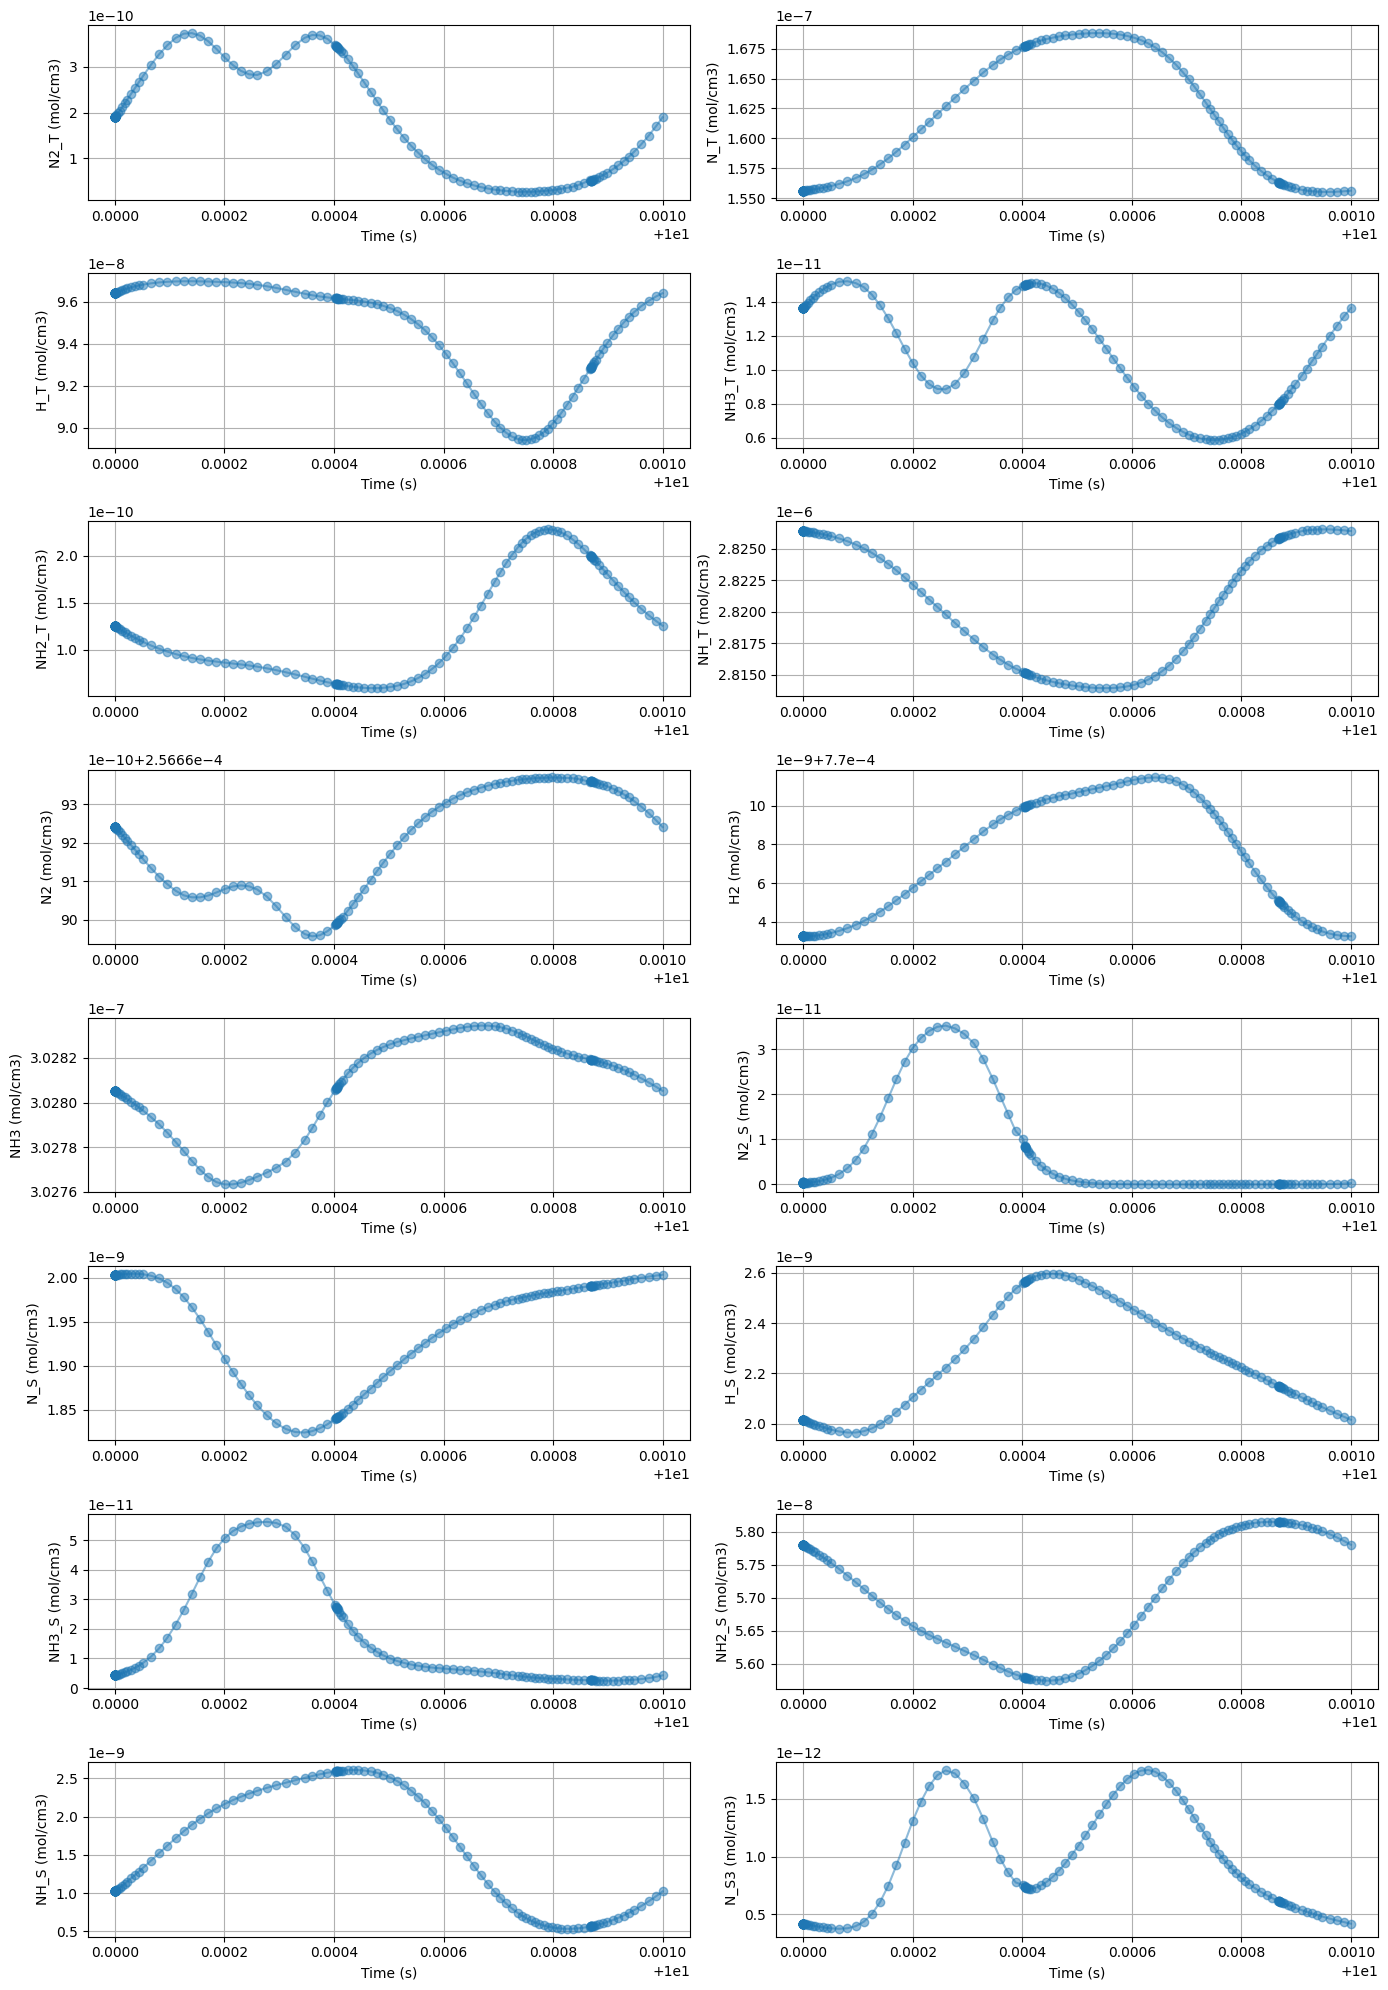

In [16]:
fig, axs = plt.subplots(8, 2, figsize=(14, 20))  
axs = axs.flatten()

column_names = [
    "N2_T", "N_T", "H_T", "NH3_T", "NH2_T", "NH_T",
    "N2", "H2", "NH3",
    "N2_S", "N_S", "H_S", "NH3_S", "NH2_S", "NH_S", "N_S3"
]

for i, name in enumerate(column_names):
    axs[i].plot((sol_.t-5), sol_.y[i], 'o-', alpha=0.5)
    axs[i].set_xlabel('Time (s)')
    axs[i].set_ylabel(f'{name} (mol/cm3)')
    axs[i].grid(True)

plt.tight_layout()
plt.show()

In [17]:
solution_df = pd.DataFrame(sol_.y.T, columns=column_names)
solution_df.insert(0, "time", sol_.t)  

csv_file_path = "solve_ivp_ammonia_solution_1000hz.csv"

solution_df.to_csv(csv_file_path, index=False)